<a href="https://colab.research.google.com/github/washwin/RamSpec_Bacterial_Classification/blob/main/convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- 1. Load Your Data ---
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds used.csv')

# Features and labels
X = df.drop(columns=['label', 'Class'])  # All columns except 'label' are spectral features
y = df['label']  # 'label' column specifies the bacteria

In [ ]:
X.shape

(895, 472)

In [ ]:
# --- 2. Encode Labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convert bacterial strain names into numeric labels

In [ ]:
# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding for multi-class classification
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=len(le.classes_))
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=len(le.classes_))

In [ ]:
# --- 4. Build the Neural Network ---
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
#     Dropout(0.3),  # Dropout for regularization
#     Dense(64, activation='relu'),  # Hidden layer
#     Dropout(0.3),
#     Dense(len(le.classes_), activation='softmax')  # Output layer with 9 classes
# ])

# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',  # Multi-class loss
#     metrics=['accuracy']
# )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Neural Network Architecture
model = Sequential([
    # Convolutional layer to capture local patterns in spectral data
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),

    # Additional convolutional layer for deeper feature extraction
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Flatten the output of Conv1D for Dense layers
    Flatten(),

    # Fully connected layers for decision-making
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer for classification
    Dense(len(le.classes_), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# --- 5. Train the Model ---
# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_onehot,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 525ms/step - accuracy: 0.1635 - loss: 18.6038 - val_accuracy: 0.0903 - val_loss: 2.1934
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1551 - loss: 11.6667 - val_accuracy: 0.1597 - val_loss: 2.2010
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1949 - loss: 5.2811 - val_accuracy: 0.0764 - val_loss: 2.2065
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1570 - loss: 3.2374 - val_accuracy: 0.1042 - val_loss: 2.1996
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2050 - loss: 2.4457 - val_accuracy: 0.0764 - val_loss: 2.2015
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2460 - loss: 2.2550 - val_accuracy: 0.0764 - val_loss: 2.2025


In [ ]:
# --- 6. Evaluate the Model ---
# Evaluate performance on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class predictions

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)


Test Accuracy: 0.15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

Classification Report:
                         precision    recall  f1-score   support

Enterobacter_aerogenes       0.00      0.00      0.00        25
 Enterococcus_faecalis       0.00      0.00      0.00        14
       Eschericia_coli       0.00      0.00      0.00        17
      Listeria_innocua       0.00      0.00      0.00        27
Listeria_monocytogenes       0.00      0.00      0.00        18
     Rhodococcus_equii       0.00      0.00      0.00        16
               S_abony       0.14      1.00      0.24        24
        Shigella_boydi       0.00      0.00      0.00        22
 Staphylococcus_aureus       1.00      0.12      0.22        16

              accuracy                           0.15       179
             macro avg       0.13      0.12      0.05       179
          weighted avg       0.11      0.15      0.05       179



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- 7. Visualize Results ---

# 1. Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3. Confusion Matrix as Heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - accuracy: 0.1720 - loss: 16.1598 - val_accuracy: 0.1528 - val_loss: 2.2260 - learning_rate: 0.0010
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.1408 - loss: 11.5475 - val_accuracy: 0.0764 - val_loss: 2.2194 - learning_rate: 0.0010
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1965 - loss: 4.3390 - val_accuracy: 0.0764 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2260 - loss: 2.5507 - val_accuracy: 0.1250 - val_loss: 2.1967 - learning_rate: 0.0010
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3300 - loss: 1.9514 - val_accuracy: 0.0764 - val_loss: 2.1981 - learning_rate: 0.0010
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4607 - loss: 1.5856 - val_accuracy: 0.0833 - val_loss: 2.1938 - learning_rate: 0.0010
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6138 - loss: 1.214

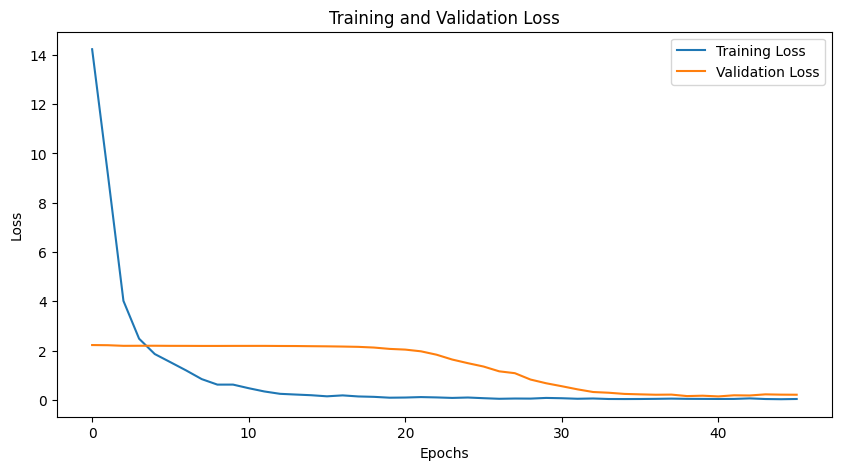

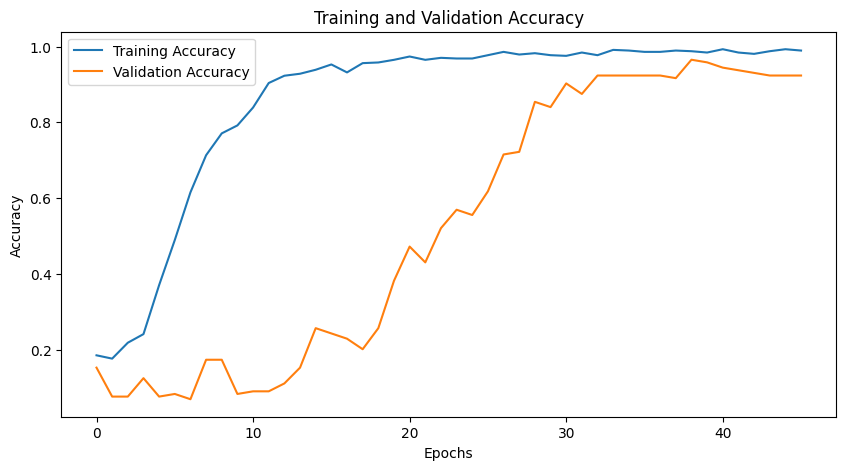

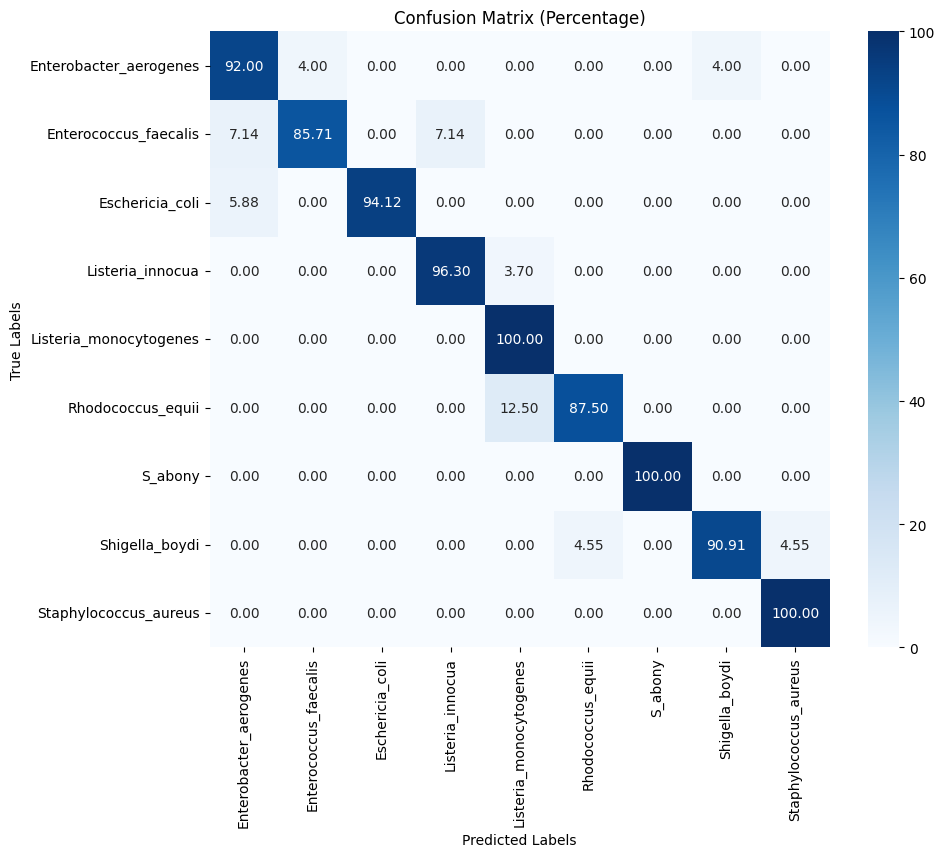

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Your Data ---
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds used.csv')

# Features and labels
X = df.drop(columns=['label', 'Class']).values  # Convert to numpy array
y = df['label']

# --- 2. Encode Labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convert bacterial strain names into numeric labels

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Reshape for CNN input (samples, features, 1)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=len(le.classes_))
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=len(le.classes_))

# --- 4. Define Neural Network Architecture ---
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(len(le.classes_), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# --- 5. Train the Model ---
history = model.fit(
    X_train, y_train_onehot,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]  # Include ReduceLROnPlateau
)

# --- 6. Evaluate the Model ---
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# --- 7. Visualize Results ---

# 1. Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3. Confusion Matrix as Heatmap
# Normalize the confusion matrix to percentages
conf_matrix_percent = conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
